# Deconvolution example

*This example is based on the code of the [sample](https://github.com/opencv/opencv/blob/master/samples/python/deconvolution.py) from OpenCV repository*

## Theory

More precisely this example shows the usage of [DFT](https://en.wikipedia.org/wiki/Discrete_Fourier_transform) to perform Weiner deconvolution of an image with user-defined point spread function ([PSF](https://en.wikipedia.org/wiki/Point_spread_function)). Following [wiki](https://en.wikipedia.org/wiki/Deconvolution): 

> In mathematics, deconvolution is an algorithm-based process used to reverse the effects of convolution on recorded data. 

In case of images, we assume that the recorded image $y$ is obtained from an 'original' $x$ convolved with a kernel $h$ (which represents motion blur, or defocusing) and noise $n$

$$ y = h * x + n $$

[Wikipedia](https://en.wikipedia.org/wiki/Wiener_deconvolution) says : 
> In mathematics, Wiener deconvolution is an application of the Wiener filter to the noise problems inherent in deconvolution. It works in the frequency domain, attempting to minimize the impact of deconvolved noise at frequencies which have a poor signal-to-noise ratio.

The idea is than to an estimate image $\hat x$ such that $\hat x = g * y$ that minimizes the mean square error.

> The Wiener deconvolution filter provides such a $g$. The filter is most easily described in the frequency domain:

> $$ G(f)={\frac {H^{*}(f)S(f)}{|H(f)|^{2}S(f)+N(f)}} $$
or 
$$ G(f) = \frac{1}{H(f)} \left[ \frac{|H(f)|^2}{ |H(f)|^2  +  \frac{1}{SNR(f)} } \right]$$

> Here,   $1/H(f)$ is the inverse of the original system, and   $\mathrm {SNR} (f)=S(f)/N(f)$ is the signal-to-noise ratio. When there is zero noise (i.e. infinite signal-to-noise), the term inside the square brackets equals 1, which means that the Wiener filter is simply the inverse of the system, as we might expect. However, as the noise at certain frequencies increases, the signal-to-noise ratio drops, so the term inside the square brackets also drops. This means that the Wiener filter attenuates frequencies dependent on their signal-to-noise ratio.

Some more interesting examples on deconvolution can be found [here](http://yuzhikov.com/articles/BlurredImagesRestoration1.htm) and [here](http://yuzhikov.com/articles/BlurredImagesRestoration2.htm).



In [3]:
from math import pi

import numpy as np
import matplotlib.pylab as plt 
import cv2
%matplotlib inline

Load an image with a motion blur

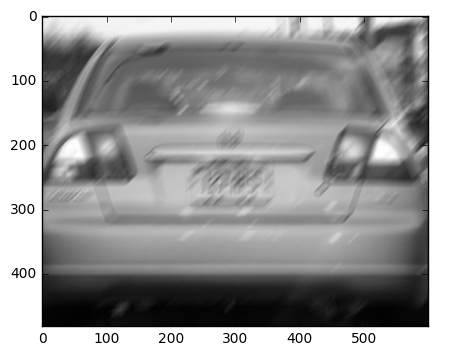

In [20]:
filename = "data/licenseplate_motion.jpg"    
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE )
assert img is not None, "File is not found"

plt.figure()
plt.imshow(img, cmap='gray')

In order to restore this image to the original one we need to define a PSF (it corresponds to $h$ variable from above equations). Let us choose a PSF as a small interval oriented in the direction of the motion blur. 

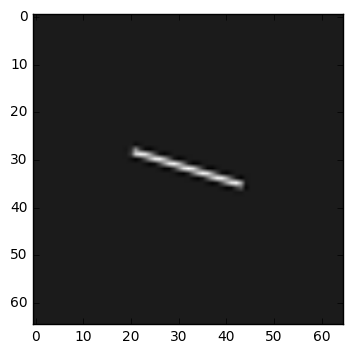

In [22]:
from ipywidgets import interact, FloatSlider

def motion_kernel(angle, d, sz=65):
    # Define an interval of length 'd'
    kern = np.ones((1, d), np.float32)
    # Define a 2d rotation matrix (OZ axe fixed)
    c, s = np.cos(angle), np.sin(angle)
    A = np.float32([[c, -s, 0], [s, c, 0]])
    # Define a translation part
    sz2 = sz // 2
    A[:,2] = (sz2, sz2) - np.dot(A[:,:2], ((d-1)*0.5, 0))
    # Apply affine transformation
    kern = cv2.warpAffine(kern, A, (sz, sz), flags=cv2.INTER_CUBIC)
    kern /= kern.sum()
    return kern


def interactive_motion_kernel(angle, d):
    plt.figure()
    k = motion_kernel( angle * pi / 180.0, d)
    plt.imshow(k, cmap='gray')
    
interact(interactive_motion_kernel,  
         angle=FloatSlider(min=0, max=90, value=0.0, continuous_update=True),
         d=FloatSlider(min=0.5, max=65, step=1.0, value=10.0, continuous_update=True))

We need to pad computed kernel to the size of the image. Thus, we obtain a PSF and we can compute a DFT of the PSF.

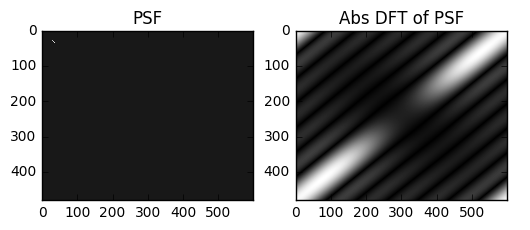

In [32]:
kernel = motion_kernel(45.0 * pi / 180.0, 10.0)
psf_pad = np.zeros_like(img, dtype=np.float32)
kh, kw = kernel.shape
psf_pad[:kh, :kw] = kernel

PSF = cv2.dft(psf_pad, flags=cv2.DFT_COMPLEX_OUTPUT, nonzeroRows = kh)

plt.figure()
plt.subplot(121)
plt.title("PSF")
plt.imshow(psf_pad, cmap='gray')
plt.subplot(122)
plt.title("Abs DFT of PSF")
plt.imshow(cv2.magnitude(PSF[:,:,0], PSF[:,:,1]), cmap='gray')

Function Signal-Noise Ratio (SNR) is unknown, therefore we approximate it by a constant value. Finally, we can compute Weiner filter $G(f)$ and perform the deconvolution.